# Interlaced Hexagonal Scanning

***

Authors:
1. Debangshu Mukherjee, _Computational Sciences & Engineering Division, Oak Ridge National Laboratory_ [mukherjeed@ornl.gov](mailto:mukherjeed@ornl.gov)
2. Jacob D. Hinkle, _Computational Sciences & Engineering Division, Oak Ridge National Laboratory_ [hinklejd@ornl.gov](mailto:hinklejd@ornl.gov)

***

## Abstract
***
Progressive acquisition of slowly-scanned images is desirable for drift-correction and realtime visualization. Interlacing methods are common approaches to storage and transmission of data on rectilinear grids, and here we propose using them for acquisition in scanning-mode image modalities. Especially in these cases, it is important to make optimal use of sample points in order to speed up the scan and reduce damage to the subject. It has long been known that optimal sampling of band-limited signals is achieved using hexagonal scanning grids. In this note, we demonstrate two new methods for interlacing hexagonal grids, which enable early full field-of-view imaging with optimal sampling and resolution doubling.
***

### Install packages as needed

In [1]:
import sys

!conda install --yes --prefix {sys.prefix} -c conda-forge numpy matplotlib py-open-fonts

Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done


### Load Packages

For this demonstration, very few packages are needed. Only `numpy` and `matplotlib` are sufficient.

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec as mpgs
import matplotlib.offsetbox as mploff
import string

### Set font parameters
This is optional, and was done only to choose the **Source Sans** family of fonts. You may delete this. To have this package available, you need the `py-open-fonts` package from **conda-forge**

In [34]:
!rm -rf ~/.cache/matplotlib
from matplotlib import rcParams

rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["Source Sans 3", "Source Sans Pro"]
rcParams["font.serif"] = ["Source Serif 4", "Source Serif Pro"]
rcParams["font.monospace"] = ["Source Code Pro"]
rcParams["font.size"] = 15
rcParams["font.weight"] = "bold"

from cycler import cycler
rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

font_size = int(12)
sc_font = {"weight": "regular", "size": font_size}
tl_font = {"weight": "bold", "size": int(1.5 * font_size)}

## Motivation

Scanning a hex scan pattern is somewhat straightforward: you do linear row scans and offset each alternating row by half a pixel. However, I have never seen Adam7-style interlacing applied to hexagonal grids. Both interlacing and close packing are desireable for scan probe patterns in STEM. In this notebook I will explore how to actually set up such a thing!

Please refer to the following link for more info on hex grids (from the top-down RPG perspective): https://www.redblobgames.com/grids/hexagons/. Note that we'll use the "pointy" coordinates there and store things in RQ order.

## Building hexagonal co-ordinates.

To do this, we need to build the hexagonal co-ordinates at a fine mesh. Let's build a mesh where the sides of the hexagons are `sd`, and we will build the co-ordinates upto a `L` distance.

Parameters chosen:
1. sd = 1
2. L = 15

Thus, if we now build two meshgrid arrays, `rs` and `qs`, starting from $-L$, stopping at $L+1$, and at `sd` steps. Now think about this, if we sum these two arrays together, we will get all the **y + x** co-ordinate points that are `sd` steps away from each other. Blanking all the values greater than **L**, then gives us our `hexmask`

In [4]:
# establish hex coordinates at the _finest_ level
sd = 1
L = 15
rs, qs = np.meshgrid(
    np.arange(start=-L, stop=L + 1, step=sd),
    np.arange(start=-L, stop=L + 1, step=sd),
)
ss = -(rs + qs)
hexmask = np.abs(ss) <= L

### Converting from cartesian to hexagonal

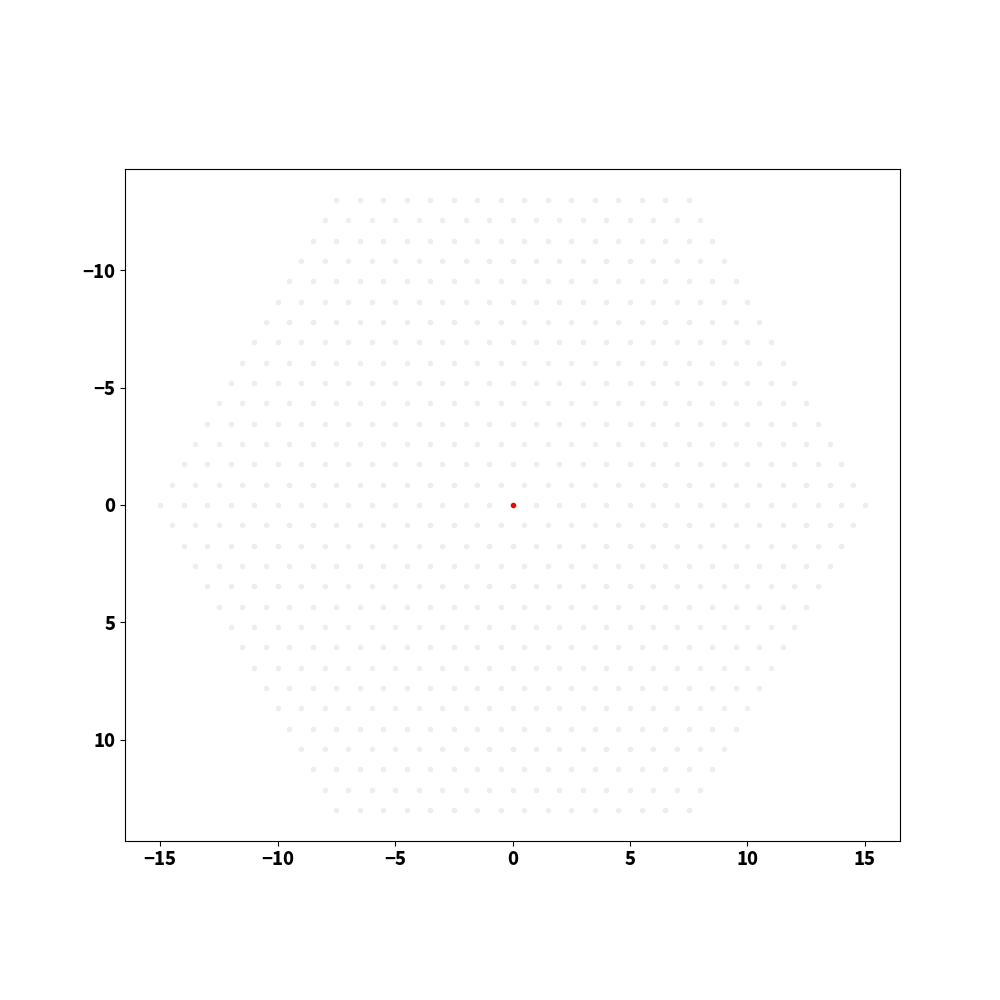

In [5]:
# convert rq to yx
eq = np.array([0.0, 1.0])
er = np.array([np.sqrt(3) / 2, 0.5])


def rq2yx(r, q):
    return r * er[0] + q * eq[0], r * er[1] + q * eq[1]


def plot_hex_grid(color="#EEE", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ys, xs = rq2yx(rs, qs)
    ax.plot(xs[hexmask], ys[hexmask], ".", color=color)


def plot_points(rqs, color="#000", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    mask = np.zeros_like(rs, dtype=bool)
    xs = [r * er[1] + q * eq[1] for r, q in rqs]
    ys = [r * er[0] + q * eq[0] for r, q in rqs]
    ax.plot(xs, ys, ".", color=color)


def plot_mask(mask, *args, **kwargs):
    r = rs[mask]
    q = qs[mask]
    rqs = np.stack((q, r), axis=-1).tolist()
    plot_points(rqs, *args, **kwargs)


fig, ax = plt.subplots(figsize=(10, 10))
plot_hex_grid(ax=ax)
plot_points([[0, 0]], color="r", ax=ax)
ax.invert_yaxis()
ax.set_aspect("equal")
# ax.axis('off');

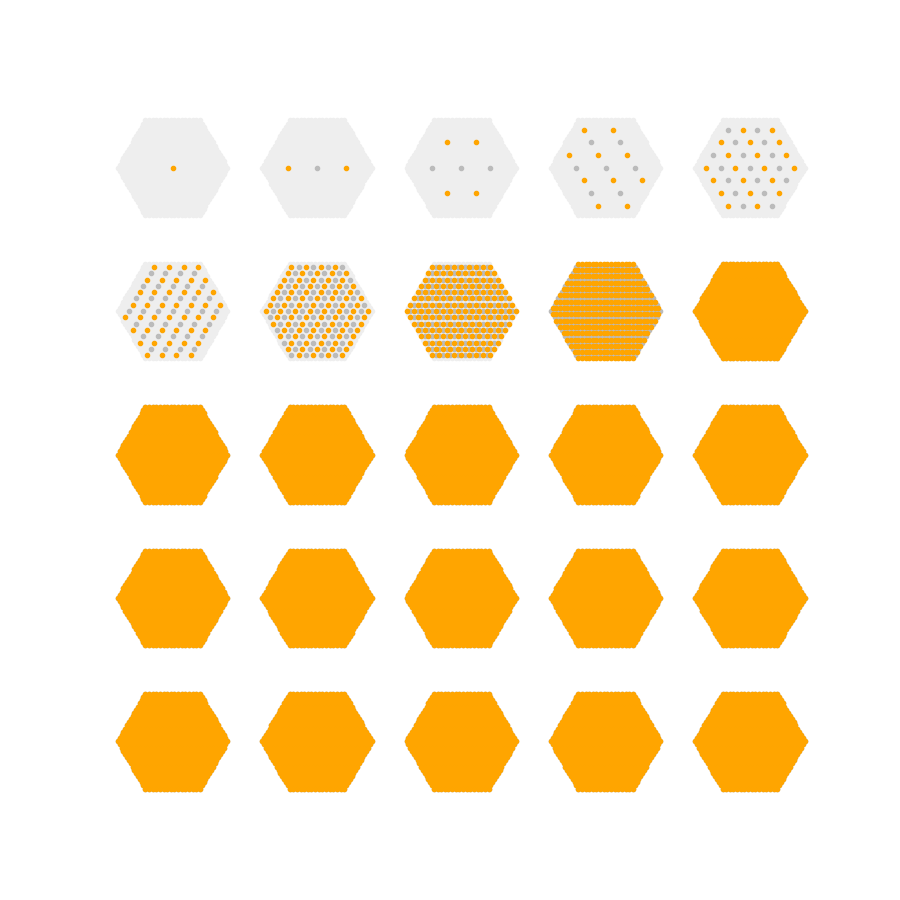

In [6]:
# this defines the order of directions that we interlace in, in RQ coords
offsets = [(0, 1), (1, 0), (-1, 1)]

# we track points in a rq grid
mask = np.zeros_like(qs, dtype=bool)
mask[L, L] = True
delta = (L + 1) // 2  # max spacing
fig, axs = plt.subplots(5, 5, figsize=(9, 9))
ax = axs[0, 0]
plot_hex_grid(ax=ax)
plot_mask(mask, color="orange", ax=ax)
ax.set_aspect("equal")
ax.axis("off")
# ax.set_title(f'Pass 1')
rad = L


def plot_circle(r, q, rad, ax):
    y, x = rq2yx(r, q)
    c = plt.Circle((x, y), rad, color="k", fill=False, zorder=5)
    ax.add_patch(c)


# plot_circle(0, 0, rad, ax)

num_points = [mask.sum()]
for p, ax in enumerate(axs.ravel()[1:]):
    # fig, ax = plt.subplots(figsize=(3, 3))
    plot_hex_grid(ax=ax)
    plot_mask(mask, color="#BBB", ax=ax)

    # compute new points
    off = offsets[p % 3]  # axis along which we are "doubling"
    new_mask = np.zeros_like(mask)
    new_points = []
    for r in range(mask.shape[0]):
        for q in range(mask.shape[1]):
            if mask[r, q]:
                # check forward and backward along offset direction
                for s in [delta, -delta]:
                    rr = r + s * off[0]
                    qq = q + s * off[1]
                    if (
                        rr >= 0
                        and qq >= 0
                        and rr < mask.shape[0]
                        and qq < mask.shape[1]
                    ):
                        new_mask[rr, qq] = hexmask[rr, qq]
                        new_points.append((rr - L, qq - L))
    if p % 2 == 1:
        delta //= 2
    rad /= np.sqrt(2)

    plot_mask(new_mask, color="orange", ax=ax)
    # for r, q in new_points:
    #    plot_circle(r, q, rad, ax=ax)
    ax.set_aspect("equal")
    ax.axis("off")
    # ax.set_title(f'Pass {p+2}')
    mask |= new_mask
    num_points.append(mask.sum())

Text(0, 0.5, 'Cumulative data/dose (percent)')

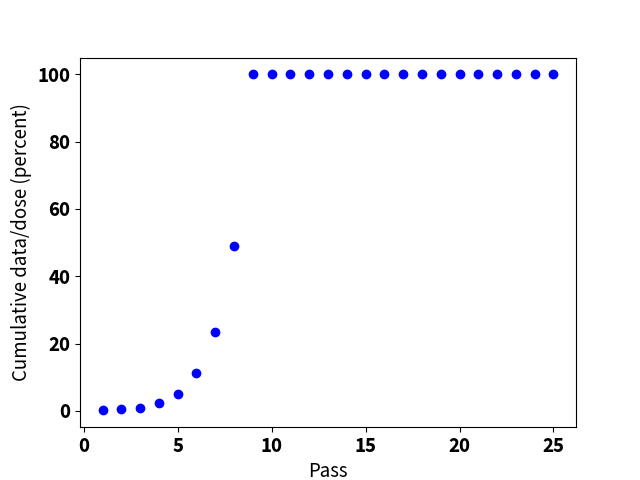

In [7]:
fig, ax = plt.subplots()
ax.plot(range(1, len(num_points) + 1), np.array(num_points) * 100 / num_points[-1], "o")
ax.set_xlabel("Pass")
ax.set_ylabel("Cumulative data/dose (percent)")
# ax.semilogy()

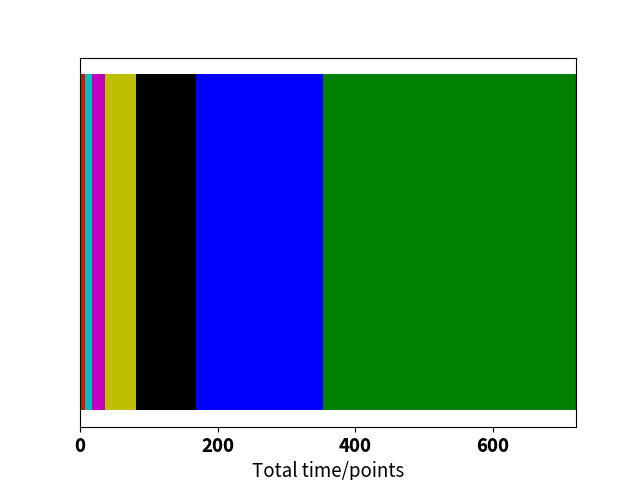

In [8]:
fig, ax = plt.subplots()
p = num_points[0]
ax.barh(0, p)
for pi in num_points[1:]:
    ax.barh(0, pi - p, left=p)
    p = pi
ax.set_xlabel("Total time/points")
ax.get_yaxis().set_visible(False)
# ax.semilogy()

In [9]:
num_points[6] / num_points[8]

0.23439667128987518

# SuperScan method

In this method, all passes are square scans (rectangular), and we only vary the width and height, rotation, and offset, of the scan.  This is to make things easy to plug into Nion Swift.

In [10]:
np.linspace(-1, 1, 9)

array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ])

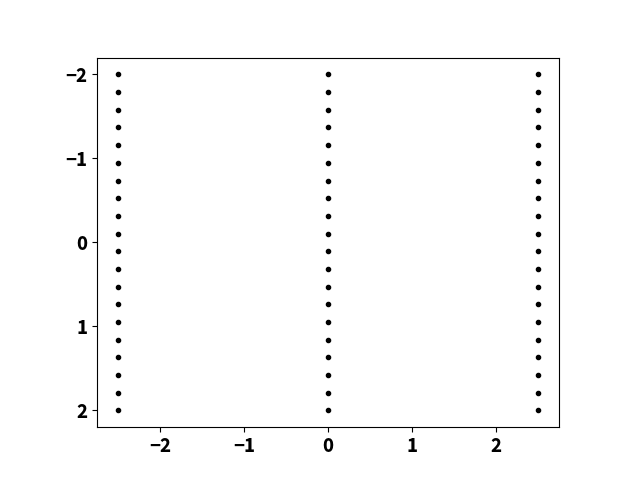

In [11]:
def cossin(t_deg):
    t = np.pi * t_deg / 180
    return -np.sin(t), np.cos(t)


def superscan_points(
    hw,
    center=(0, 0),  # Not sure how to input this into Nion just yet!
    theta_deg=0,
    *,
    fov=None,
    spacing=None,
):
    """Return collection of points for a SuperScan."""
    h, w = hw
    if (fov is None and spacing is None) or (fov is not None and spacing is not None):
        raise ValueError("Must provide either fov or spacing")
    if fov is None:
        fov = (h - 1) * spacing[0], (w - 1) * spacing[1]
    y, x = np.meshgrid(
        np.linspace(-fov[0] / 2, fov[0] / 2, h),
        np.linspace(-fov[1] / 2, fov[1] / 2, w),
        indexing="ij",
    )
    scan = np.array([y, x])
    c, s = cossin(theta_deg)
    # NOTE: R rotates around positive Z.
    # In a ZYX coordinate system, this is _into_ the screen.
    R = np.array(
        [
            [c, -s],
            [s, c],
        ]
    )
    scan = np.einsum("ed,dhw->ehw", R, scan)
    scan += np.array(center).reshape(-1, 1, 1)
    return scan


def hex_superscan_pair(
    fov,
    hw,
    center,
    theta_deg,
):
    """Compute a pair of staggered superscans whose union is a hex grid"""
    h, w = hw
    # get size in Y for each scan, such that total is H
    h1 = h // 2
    h2 = h - h1


scan = superscan_points((3, 20), fov=(5, 4), center=(0, 0.0), theta_deg=0)
fig, ax = plt.subplots()
ax.plot(scan[1], scan[0], ".k")
ax.set_aspect("equal")
ax.invert_yaxis()

# Rotating method

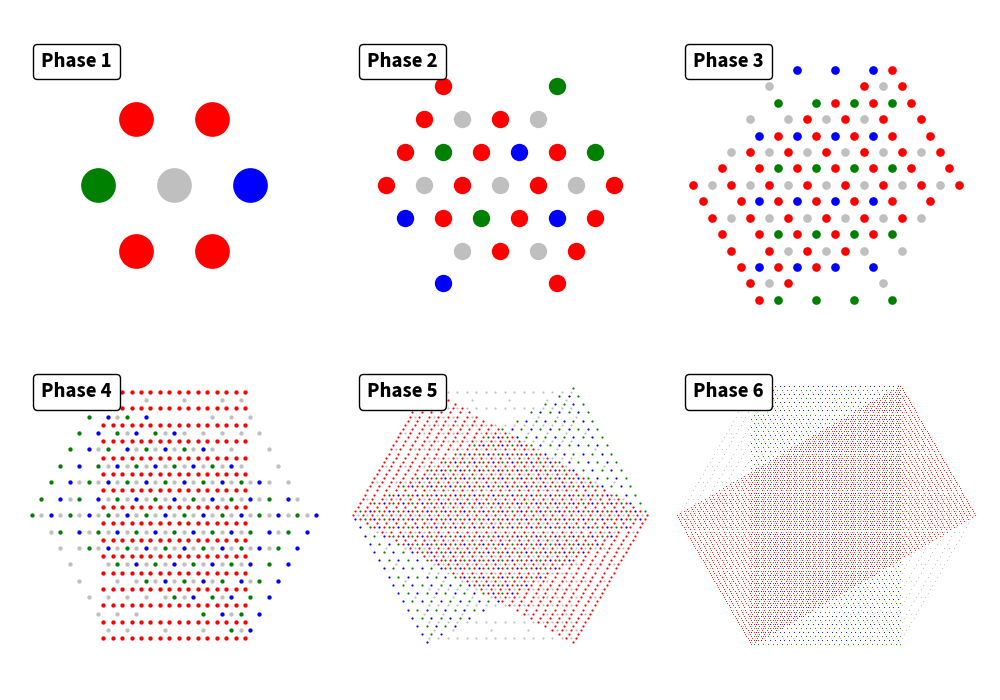

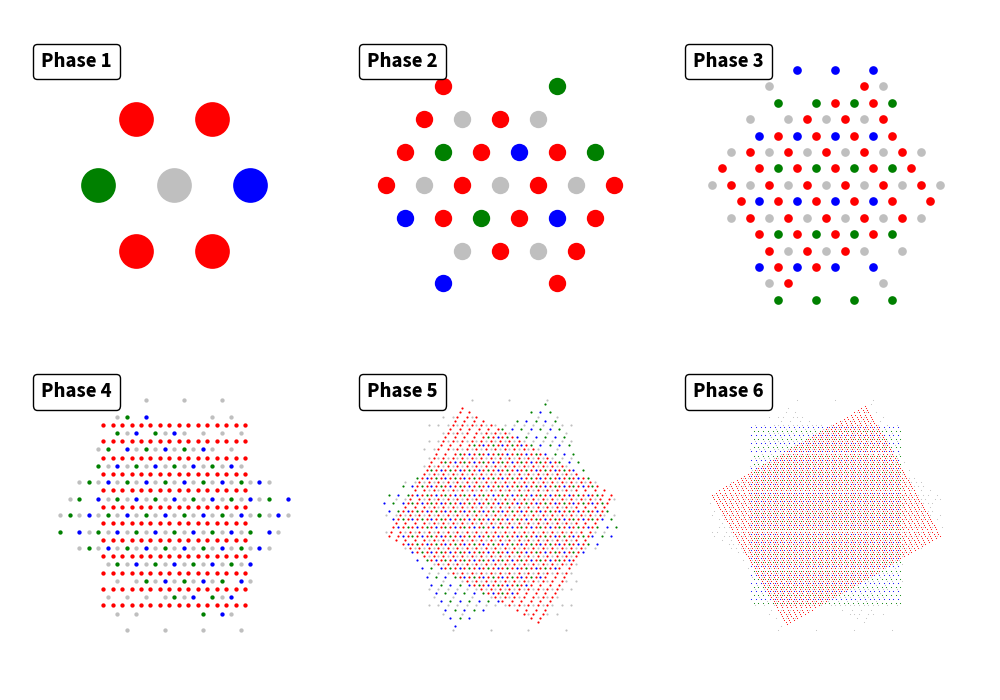

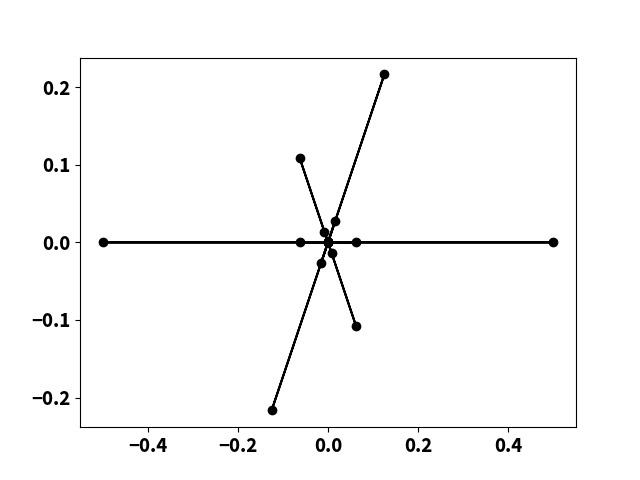

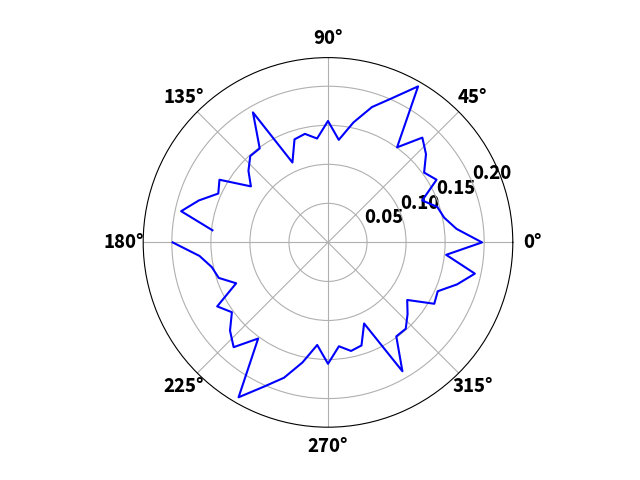

In [12]:
def plot_passes(
    ax,
    num_passes=7,
    gray_passes=4,
    reduce_H_after_n_passes=None,
    cmap=plt.cm.jet,
    ms=300,
    title=None,
    legend=False,
    theta_deg=-120,
    trim=False,
    addbox=False,
):
    ax.set_aspect("equal")
    # ax.invert_yaxis()
    center = np.array([0.0, 0.0])
    HW = np.array([1, 1])
    # start with w-spacing along X, sqrt(3) w along Y
    basespacing = np.array([1, np.sqrt(3)])
    # start with big w
    w = 1.0

    center = np.array(cossin(theta_deg)) * w
    centers = []
    pts = []
    for i in range(num_passes):
        if i % 3 == 0:  # green
            cs = np.array(cossin(theta_deg))
            # undo center point from last pass, reset to zero
            center -= w * cs
            scan = superscan_points(
                HW,
                spacing=basespacing * w,
                center=center,
                theta_deg=theta_deg,
            )
            theta_deg += 60
            # ms /= np.sqrt(2)
        elif i % 3 == 1:  # blue
            # same grid as last pass, but rotated and offset
            cs = np.array(cossin(theta_deg + 60))
            center -= w * cs / 2
            scan = superscan_points(
                HW,
                spacing=basespacing * w,
                center=center,
                theta_deg=theta_deg,
            )
            # ms /= np.sqrt(2)
        elif i % 3 == 2:  # orange
            cs = np.array(cossin(theta_deg + 60))
            center += w * cs * 1.0
            scan = superscan_points(
                HW,
                spacing=basespacing * w,
                center=center,
                theta_deg=theta_deg,
            )
            theta_deg += 60
            w /= 2
            HW *= 2

        if trim:
            phase = (i + 1) // 3
            subphase = (i + 1) % 3
            if phase > 2 and phase % 2 == 1:
                if subphase == 0:
                    HW[1] -= 2

        centers.append(center.copy())
        alpha = min(200 / ms**2, 1)
        alpha = 0.5 if i < gray_passes else 1
        # ms = 10
        if i < gray_passes:
            label = None
        elif i - gray_passes == 0:
            label = "Base"
        elif i - gray_passes == 1:
            label = "Shift"
        elif i - gray_passes == 2:
            label = "Double/Rotate"
        else:
            label = "Pass {i}"
        color = "gray" if i < gray_passes else None
        ax.plot(
            scan[1].ravel(),
            scan[0].ravel(),
            ".",
            markersize=ms,
            color=color,
            mec="none",
            alpha=alpha,
            label=label,
            lw=0.0,
        )
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        # HW[i % 2] *= 2
        # center += axes[(i + 1) % 3] / 2 ** i
        pts = pts + scan.reshape(2, -1).T.tolist()
    if addbox:
        at = mploff.AnchoredText(s=title, frameon=True, loc="upper left")
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax.add_artist(at)
    else:
        ax.set_title(title)
    if legend:
        ax.legend(bbox_to_anchor=(1, 1), loc="upper left")
    # ax.grid()
    ax.set_axis_off()
    return centers, np.asarray(pts)


fig, axs = plt.subplots(2, 3, figsize=(10, 7))
axs = axs.ravel()
for i, ax in enumerate(axs):
    centers, pts = plot_passes(
        ax=axs[i],
        theta_deg=60,
        num_passes=3 * i + 4,
        gray_passes=3 * i + 1,
        title=f"Phase {i+1}",
        ms=100 / 2 ** (i + 1),
        reduce_H_after_n_passes=7,
        trim=False,
        addbox=True,
    )
fig.tight_layout()
fig.savefig("../latex/rotating_phases.pdf", bbox_inches="tight")

fig, axs = plt.subplots(2, 3, figsize=(10, 7))
axs = axs.ravel()
for i, ax in enumerate(axs):
    centers, pts = plot_passes(
        ax=axs[i],
        theta_deg=60,
        num_passes=3 * i + 4,
        gray_passes=3 * i + 1,
        title=f"Phase {i+1}",
        ms=100 / 2 ** (i + 1),
        reduce_H_after_n_passes=7,
        trim=True,
        addbox=True,
    )
fig.tight_layout()
fig.savefig("../latex/rotating_phases_trimmed.pdf", bbox_inches="tight")

fig, ax = plt.subplots()
ax.plot([b for a, b in centers], [a for a, b in centers], "-ok")

phi = np.arctan2(pts[:, 0], pts[:, 1])  # * 180 / np.pi
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
n, b = np.histogram(phi, 60, density=True)
ax.plot(b[:-1], n)
pts.shape
fig.savefig("../latex/angular_distribution.pdf", bbox_inches="tight")

# Basic method

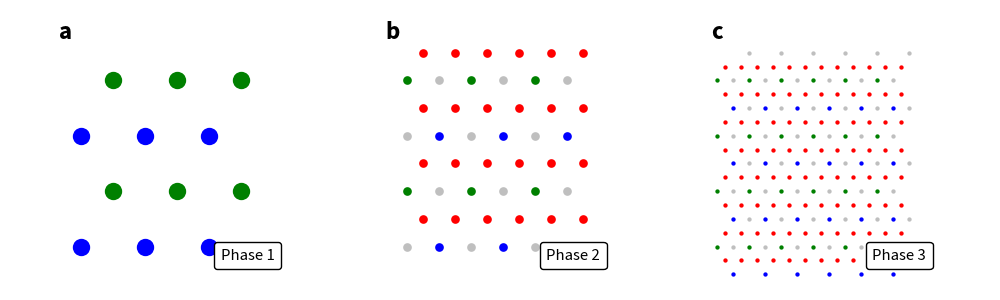

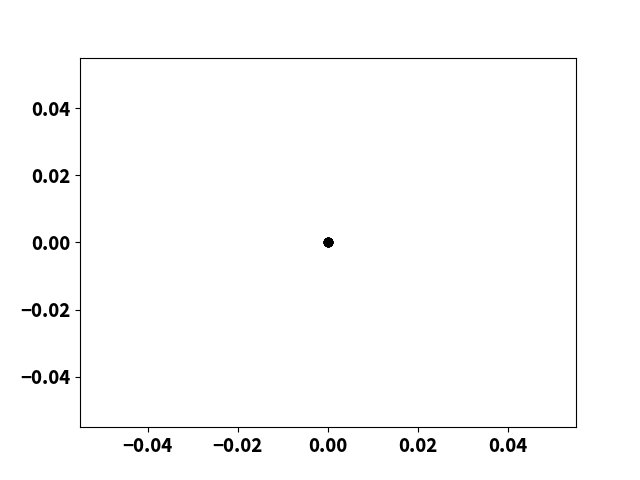

In [44]:
def plot_passes_rect(
    ax,
    getnum,
    num_passes=7,
    gray_passes=4,
    # cmap = plt.cm.PuBuGn_r
    cmap=plt.cm.jet,
    # plt.rcParams["axes.prop_cycle"] = plt.cycler(
    #    "color",
    #    cmap(np.arange(num_passes) % cmap.N if cmap.N < 100 else np.linspace(0, .8, num_passes)),
    # )
    ms=300,
    title=None,
    addbox=True,
    legend=False,
):
    ax.set_aspect("equal")
    # ax.invert_yaxis()
    center = np.array([0.0, 0.0])
    HW = np.array([3, 2])
    # start with w-spacing along X, sqrt(3) w along Y
    basespacing = np.array([1, np.sqrt(3)])
    centerstep = np.array([np.sqrt(3), 1])
    # start with big w
    w = 1.0

    # center = np.array(cossin(theta_deg)) * w
    centers = []
    for i in range(num_passes):
        if i == 0:
            scan = superscan_points(
                HW,
                spacing=basespacing * w,
                center=center,
                theta_deg=0,
            )
        elif i == 1:
            scan = superscan_points(
                HW,
                spacing=basespacing * w,
                center=center + 0.5 * w * np.array([np.sqrt(3), 1]),
                theta_deg=0,
            )
        elif (i - 2) % 3 == 0:
            scan = superscan_points(
                HW,
                spacing=basespacing * w,
                center=center + 0.5 * w * np.array([0, 1]) * (-1) ** ((i - 2) % 3),
                theta_deg=0,
            )
        elif (i - 2) % 3 == 1:
            scan = superscan_points(
                HW,
                spacing=basespacing * w,
                center=center
                + 0.5 * w * np.array([np.sqrt(3), 0]),  # * (-1) ** ((i - 2) % 3),
                theta_deg=0,
            )
        elif (i - 2) % 3 == 2:
            # same grid as last pass, but rotated and offset
            HW *= 2
            w /= 2
            scan = superscan_points(
                HW,
                spacing=basespacing * w,
                center=center
                + w * np.array([np.sqrt(3), 1]),  # * (-1) ** ((i - 2) % 3),
                theta_deg=0,
            )
        centers.append(center.copy())
        alpha = min(200 / ms**2, 1)
        alpha = 0.5 if i < gray_passes else 1
        # ms = 10
        color = "gray" if i < gray_passes else None
        ax.plot(
            scan[1].ravel(),
            scan[0].ravel(),
            ".",
            markersize=ms,
            color=color,
            mec="none",
            alpha=alpha,
            label=None,
            lw=0.0,
        )
        
        ax.set_xlim(-1.35, 2.25)
        ax.set_ylim(-1.35, 2.25)
        # HW[i % 2] *= 2
        # center += axes[(i + 1) % 3] / 2 ** i
    if addbox:
        at = mploff.AnchoredText(s=title, frameon=True, prop=sc_font, loc="lower right")
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax.add_artist(at)
        ax.set_title(label=string.ascii_lowercase[getnum], loc="left", fontdict=tl_font)
    if legend:
        ax.legend(bbox_to_anchor=(1, 1), loc="lower right")
    # ax.grid()
    ax.set_axis_off()
    return centers


fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs = axs.ravel()
for ii, ax in enumerate(axs):
    centers = plot_passes_rect(
        ax=axs[ii],
        getnum=ii,
        num_passes=3 * ii + 2,
        gray_passes=3 * (ii - 1) + 2,
        title=f"Phase {ii+1}",
        ms=50 / 2 ** (ii + 1),
    )
fig.tight_layout()
fig.savefig("../latex/basic_phases.pdf", bbox_inches="tight")
# centers = plot_passes(ax=axs[0], num_passes=4, gray_passes=1, title='Phase 1')
# centers = plot_passes(ax=axs[1], num_passes=7, gray_passes=4, title='Phase 2')
# centers = plot_passes(ax=axs[2], num_passes=10, gray_passes=7, title='Phase 3', legend=True)

fig, ax = plt.subplots()
ax.plot([b for a, b in centers], [a for a, b in centers], "-ok")
# ax.invert_yaxis()


# Scanline interlacing

Scanline method is super simple, just repeatedly doubles one dimension.

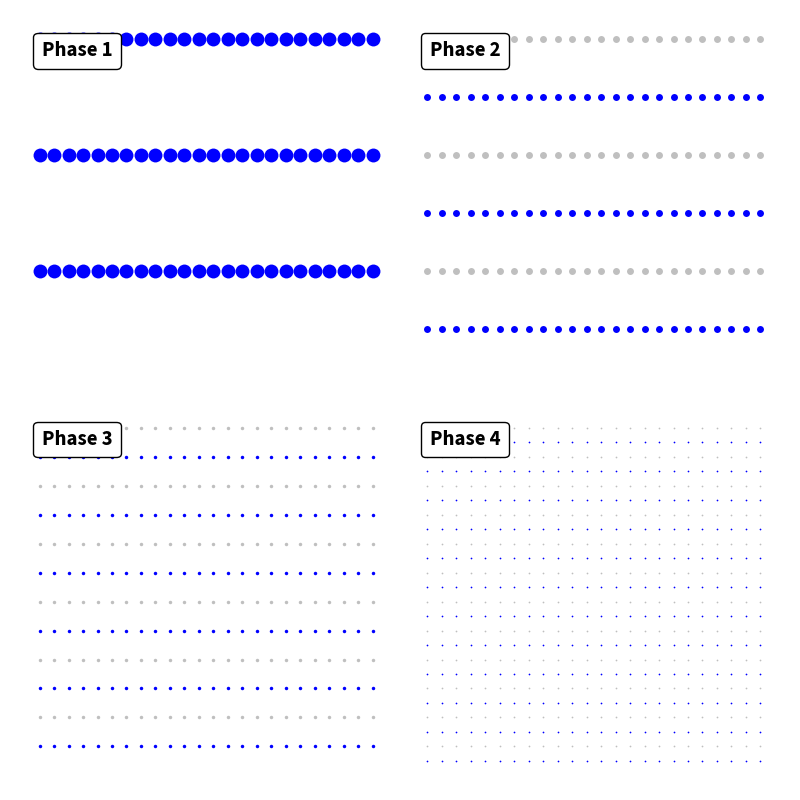

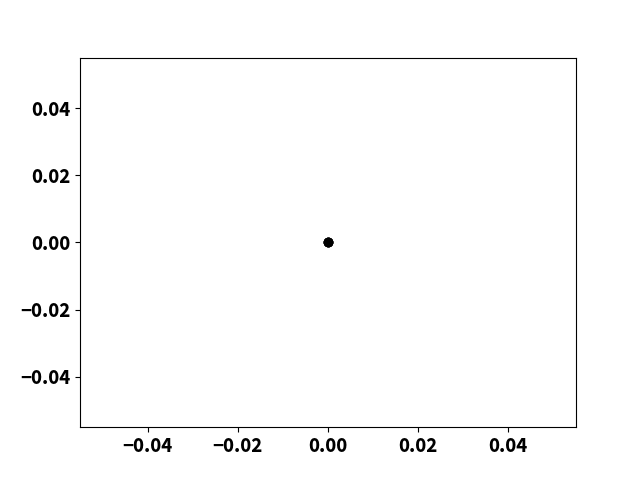

In [14]:
def plot_passes_scanline(
    ax,
    num_passes=7,
    gray_passes=4,
    xres=32,
    cmap=plt.cm.jet,
    ms=300,
    title=None,
    legend=False,
    addbox=False,
):
    ax.set_aspect("equal")
    # ax.invert_yaxis()
    center = np.array([0.0, 0.0])
    HW = np.array([24, 3])
    # start with w-spacing along X, sqrt(3) w along Y
    spacing = np.array([1 / 8, 1], dtype=np.float64)

    # get first three colors in matplotlib color cycle, so we can match later plots
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # center = np.array(cossin(theta_deg)) * w
    centers = []
    for i in range(num_passes):
        center = np.array(((-0.5) ** (i), 0)) * spacing
        # center = 0.5 * spacing
        center[0] = 0
        if i == 0:
            # center[1] -= .5 * spacing[1]
            scan = superscan_points(
                HW,
                spacing=spacing,
                center=center + np.array([0.5, 0]),
                theta_deg=0,
            )
        else:
            # double first dim
            scan = superscan_points(
                HW,
                spacing=spacing,
                center=center,
                theta_deg=0,
            )
            spacing[1] /= 2
            HW[1] *= 2

        centers.append(center.copy())
        alpha = min(200 / ms**2, 1)
        alpha = 0.5 if i < gray_passes else 1

        if i < gray_passes:
            label = None
            color = "gray"
        else:
            label = "Pass {i}"
            color = colors[0]  # blue

        ax.plot(
            scan[1].ravel(),
            scan[0].ravel(),
            ".",
            markersize=ms,
            color=color,
            mec="none",
            alpha=alpha,
            label=label,
            lw=0.0,
        )
        # ax.set_ylim(-2, 1.2)
        # ax.set_xlim(-1.2, 2)
        # HW[i % 2] *= 2
        # center += axes[(i + 1) % 3] / 2 ** i
    if addbox:
        at = mploff.AnchoredText(s=title, frameon=True, loc="upper left")
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax.add_artist(at)
    else:
        ax.set_title(title)
    if legend:
        ax.legend(bbox_to_anchor=(1, 1), loc="upper left")
    # ax.grid()
    ax.set_axis_off()
    return centers


fig, axs = plt.subplots(
    2,
    2,
    sharey=True,
    sharex=True,
    figsize=(8, 8),
)
axs = axs.ravel()
for ii, ax in enumerate(axs):
    centers = plot_passes_scanline(
        ax=axs[ii],
        num_passes=ii + 1,
        gray_passes=ii,
        title=f"Phase {ii+1}",
        ms=40 / 2 ** (ii + 1),
        addbox=True,
    )
fig.tight_layout()

fig.savefig("../latex/scanline_phases.pdf", bbox_inches="tight")

fig, ax = plt.subplots()
ax.plot([b for a, b in centers], [a for a, b in centers], "-ok")

# Adam7

In [15]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['b', 'g', 'r', 'c', 'm', 'y', 'k']


0 0
color b
0 1
color gray
1 1
color b
2 1
color r
0 3
color gray
1 3
color gray
2 3
color gray
3 3
color b
4 3
color r
0 5
color gray
1 5
color gray
2 5
color gray
3 5
color gray
4 5
color gray
5 5
color b
6 5
color r


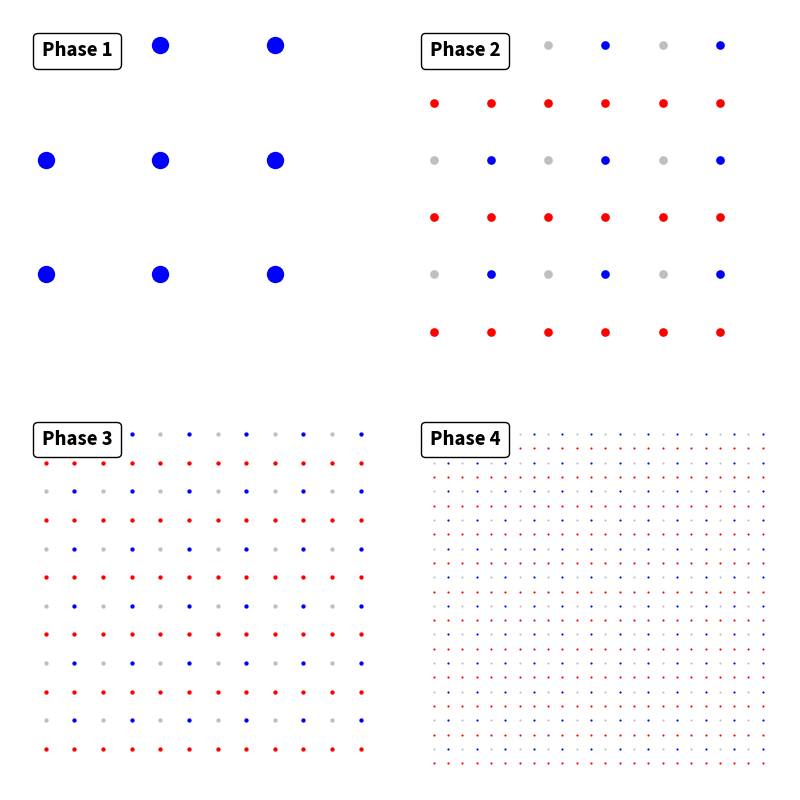

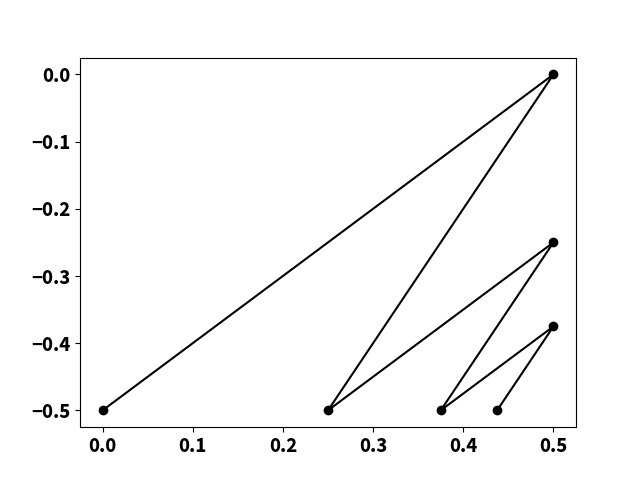

In [16]:
def plot_passes_adam7(
    ax,
    num_passes=7,
    gray_passes=4,
    cmap=plt.cm.jet,
    ms=300,
    title=None,
    legend=False,
    addbox=False,
):
    ax.set_aspect("equal")
    # ax.invert_yaxis()
    center = np.array([0.0, 0.0])
    HW = np.array([3, 3])
    # start with w-spacing along X, sqrt(3) w along Y
    spacing = np.array([1, 1], dtype=np.float64)
    centerstep = np.array([1, 1])

    # get first three colors in matplotlib color cycle, so we can match later plots
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # center = np.array(cossin(theta_deg)) * w
    centers = []
    for i in range(num_passes):
        if i == 0:
            scan = superscan_points(
                HW,
                spacing=spacing,
                center=center,
                theta_deg=0,
            )
            center -= spacing / 2 * np.array([1, 0])
        elif (i - 1) % 2 == 0:
            # double first dim
            center += spacing / 2 * np.array([1, 1.0])
            scan = superscan_points(
                HW,
                spacing=spacing,
                center=center,
                theta_deg=0,
            )
            spacing[0] /= 2
            HW[0] *= 2
        elif (i - 1) % 2 == 1:
            # double second dim
            center += spacing * np.array([-1, -0.25])
            scan = superscan_points(
                HW,
                spacing=spacing,
                center=center,
                theta_deg=0,
            )
            spacing[1] /= 2
            HW[1] *= 2
        centers.append(center.copy())
        alpha = min(200 / ms**2, 1)
        alpha = 0.5 if i < gray_passes else 1
        # ms = 10
        if i < gray_passes:
            label = None
        elif i - gray_passes == 0:
            label = "Base"
        elif i - gray_passes == 1:
            label = "Shift"
        else:
            label = "Pass {i}"

        if i < gray_passes:
            label = None
        elif i - gray_passes == 0:
            label = "Base"
        elif i - gray_passes == 1:
            label = "Shift"
        else:
            label = "Pass {i}"

        print(i, gray_passes)
        if i < gray_passes:
            color = "gray"
        elif (i - gray_passes) == 0:
            # TODO: get actual first color from colormap
            color = colors[0]  # blue
        elif (i - gray_passes) == 1:
            color = colors[2]  # green
        else:
            color = None
        print("color", color)
        ax.plot(
            scan[1].ravel(),
            scan[0].ravel(),
            ".",
            markersize=ms,
            color=color,
            mec="none",
            alpha=alpha,
            label=label,
            lw=0.0,
        )
        ax.set_ylim(-2, 1.2)
        ax.set_xlim(-1.2, 2)
    if addbox:
        at = mploff.AnchoredText(s=title, frameon=True, loc="upper left")
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax.add_artist(at)
    if legend:
        ax.legend(bbox_to_anchor=(1, 1), loc="upper left")
    # ax.grid()
    ax.set_axis_off()
    return centers


fig, axs = plt.subplots(
    2,
    2,
    sharey=True,
    sharex=True,
    figsize=(8, 8),
)
axs = axs.ravel()
for i, ax in enumerate(axs):
    centers = plot_passes_adam7(
        ax=axs[i],
        num_passes=2 * i + 1,
        gray_passes=max(2 * (i - 1) + 1, 0),
        title=f"Phase {i+1}",
        ms=50 / 2 ** (i + 1),
        addbox=True,
        legend=False,
    )
fig.tight_layout()

fig.savefig("../latex/adam7_phases.pdf", bbox_inches="tight")


fig, ax = plt.subplots()
ax.plot([b for a, b in centers], [a for a, b in centers], "-ok")


# Hex drawing and density plots

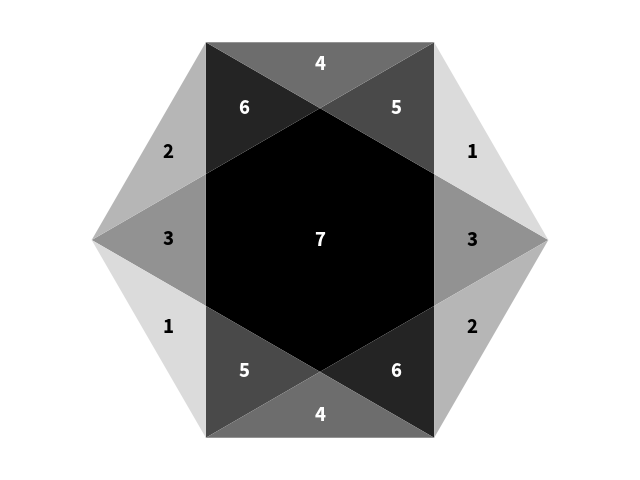

In [17]:
import matplotlib
import matplotlib.cm as cm
from matplotlib.patches import Polygon


def rotate_points(pts, theta_rad):
    c = np.cos(theta_rad)
    s = np.sin(theta_rad)
    return np.vstack(
        [
            c * pts[:, 0] - s * pts[:, 1],
            s * pts[:, 0] + c * pts[:, 1],
        ]
    ).T


def unit_hex_points():
    """
    Hex points in clockwise order, for a hexagon with side length 1 and a vertex at the top.
    """
    # I'm using notation from wikipedia https://en.wikipedia.org/wiki/Hexagon#Parameters
    t = 1.0
    r = np.sqrt(3) / 2 * t
    return rotate_points(
        np.array(
            [
                [0, t],
                [r, t / 2],
                [r, -t / 2],
                [0, -t],
                [-r, -t / 2],
                [-r, t / 2],
            ]
        ),
        np.pi / 6,
    )


def plot_polyline(pts, ax, close=True, **kwargs):
    # tack on first point to the end to close the contour
    if close:
        pts = np.vstack([pts, pts[[0]]])
    return ax.plot(pts[:, 0], pts[:, 1], **kwargs)


def draw_hex(
    ax,
    exterior_outline=1,
    draw_diameters=0,
    draw_chords=0,
    interior_weight=None,  # Provide values here to color triangles, in order to display densities
    horn_weights=None,
    side_weights=None,
    vmin=0,
    vmax=1,
    cmap=None,
):
    extpts = unit_hex_points()
    a, b, c, d, e, f = extpts.tolist()

    # plot invisible points so that the image extent is set properly
    ax.plot(extpts[:, 0], extpts[:, 1], alpha=0)

    # scale and rotate exterior polygon to get interior polygon
    intpts = rotate_points(extpts * np.sqrt(3) / 3, np.pi / 6)

    A, B, C, D, E, F = intpts.tolist()

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)

    if interior_weight is not None:
        # plot a hexagon in the interior as a color given by colormap
        # plot_polyline(intpts, ax, color='b')
        p = Polygon(intpts, edgecolor=None, facecolor=mapper.to_rgba(interior_weight))
        ax.add_patch(p)
        ax.text(
            0,
            0,
            # f'{interior_weight:.03f}',
            str(interior_weight),
            ha="center",
            va="center",
            color="white",
        )

    if horn_weights is not None:
        if not isinstance(horn_weights, (list, tuple)):
            horn_weights = 6 * [horn_weights]
        for u, v, w, wt in zip(
            intpts.tolist(),
            extpts.tolist(),
            np.roll(intpts, -1, axis=0).tolist(),
            horn_weights,
        ):
            ax.add_patch(
                Polygon([u, v, w], edgecolor=None, facecolor=mapper.to_rgba(wt))
            )
            x = (u[0] + v[0] + w[0]) / 3
            y = (u[1] + v[1] + w[1]) / 3
            ax.text(
                x,
                y,
                # f'{wt:.03f}'
                str(wt),
                ha="center",
                va="center",
                color="white" if wt / interior_weight > 0.5 else "black",
            )
        # ax.add_patch(Polygon([A, a, B], edgecolor=None, facecolor=mapper.to_rgba(horn_weights[0])))
        # ax.add_patch(Polygon([B, b, C], edgecolor=None, facecolor=mapper.to_rgba(horn_weights[1])))
        # ax.add_patch(Polygon([C, c, D], edgecolor=None, facecolor=mapper.to_rgba(horn_weights[2])))
        # ax.add_patch(Polygon([D, d, E], edgecolor=None, facecolor=mapper.to_rgba(horn_weights[3])))
        # ax.add_patch(Polygon([E, e, F], edgecolor=None, facecolor=mapper.to_rgba(horn_weights[4])))
        # ax.add_patch(Polygon([F, f, A], edgecolor=None, facecolor=mapper.to_rgba(horn_weights[5])))

    if side_weights is not None:
        if not isinstance(side_weights, (list, tuple)):
            side_weights = 6 * [side_weights]

        for u, v, w, wt in zip(
            extpts.tolist(),
            np.roll(intpts, -1, axis=0).tolist(),
            np.roll(extpts, -1, axis=0).tolist(),
            side_weights,
        ):
            ax.add_patch(
                Polygon([u, v, w], edgecolor=None, facecolor=mapper.to_rgba(wt))
            )
            x = (u[0] + v[0] + w[0]) / 3
            y = (u[1] + v[1] + w[1]) / 3
            ax.text(
                x,
                y,
                # f'{wt:.03f}',
                str(wt),
                ha="center",
                va="center",
                color="white" if wt / interior_weight > 0.5 else "black",
            )
        # ax.add_patch(Polygon([a, B, b], edgecolor=None, facecolor=mapper.to_rgba(side_weights[0])))
        # ax.add_patch(Polygon([b, C, c], edgecolor=None, facecolor=mapper.to_rgba(side_weights[1])))
        # ax.add_patch(Polygon([c, D, d], edgecolor=None, facecolor=mapper.to_rgba(side_weights[2])))
        # ax.add_patch(Polygon([d, E, e], edgecolor=None, facecolor=mapper.to_rgba(side_weights[3])))
        # ax.add_patch(Polygon([e, F, f], edgecolor=None, facecolor=mapper.to_rgba(side_weights[4])))
        # ax.add_patch(Polygon([f, A, a], edgecolor=None, facecolor=mapper.to_rgba(side_weights[5])))

    if exterior_outline:
        plot_polyline(extpts, ax, color="k")

    if draw_diameters:
        plot_polyline(np.vstack([a, d]), ax, color="k")
        plot_polyline(np.vstack([b, e]), ax, color="k")
        plot_polyline(np.vstack([c, f]), ax, color="k")

    if draw_chords:
        plot_polyline(np.vstack([a, c]), ax, color="k")
        plot_polyline(np.vstack([b, d]), ax, color="k")
        plot_polyline(np.vstack([c, e]), ax, color="k")
        plot_polyline(np.vstack([d, f]), ax, color="k")
        plot_polyline(np.vstack([e, a]), ax, color="k")
        plot_polyline(np.vstack([f, b]), ax, color="k")

    return mapper


fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_axis_off()
# fig.colorbar(
draw_hex(
    ax,
    exterior_outline=False,
    interior_weight=7,  # 1.0
    vmax=7,
    # draw_diameters=True,
    # horn_weights=[0.85714286, 0.71428571, 0.42857143, 0.85714286, 0.71428571, 0.42857143], #[0.75,0.5,  0.25, 0.75, 0.5,  0.25], # new
    # side_weights=[0.57142858, 0.14285715, 0.28571429, 0.57142858, 0.14285715, 0.28571429], #[0.5, 0.,   0.25, 0.5,  0.,   0.25], # new
    horn_weights=[6, 5, 3, 6, 5, 3],
    side_weights=[4, 1, 2, 4, 1, 2],
    cmap="gray_r",
),
#   ax=ax)

fig.tight_layout()
fig.savefig("../latex/converged_hex_density.pdf", bbox_inches="tight")
# isum, hsum, ssum

[0.8        0.26666667 0.53333333 0.8        0.26666667 0.53333333] [1.06666667 0.8        0.53333333 1.06666667 0.8        0.53333333]
[0.63492063 0.19047619 0.31746032 0.63492063 0.19047619 0.31746032] [0.88888889 0.76190476 0.44444444 0.88888889 0.76190476 0.44444444]
[0.58039216 0.15686275 0.29803922 0.58039216 0.15686275 0.29803922] [0.8627451  0.72156863 0.43921569 0.8627451  0.72156863 0.43921569]
[0.57478006 0.14467253 0.28934506 0.57478006 0.14467253 0.28934506] [0.86021505 0.71554252 0.43010753 0.86021505 0.71554252 0.43010753]


Text(0.5, 0.98, 'Approximate Relative Sampling Density By Phase')

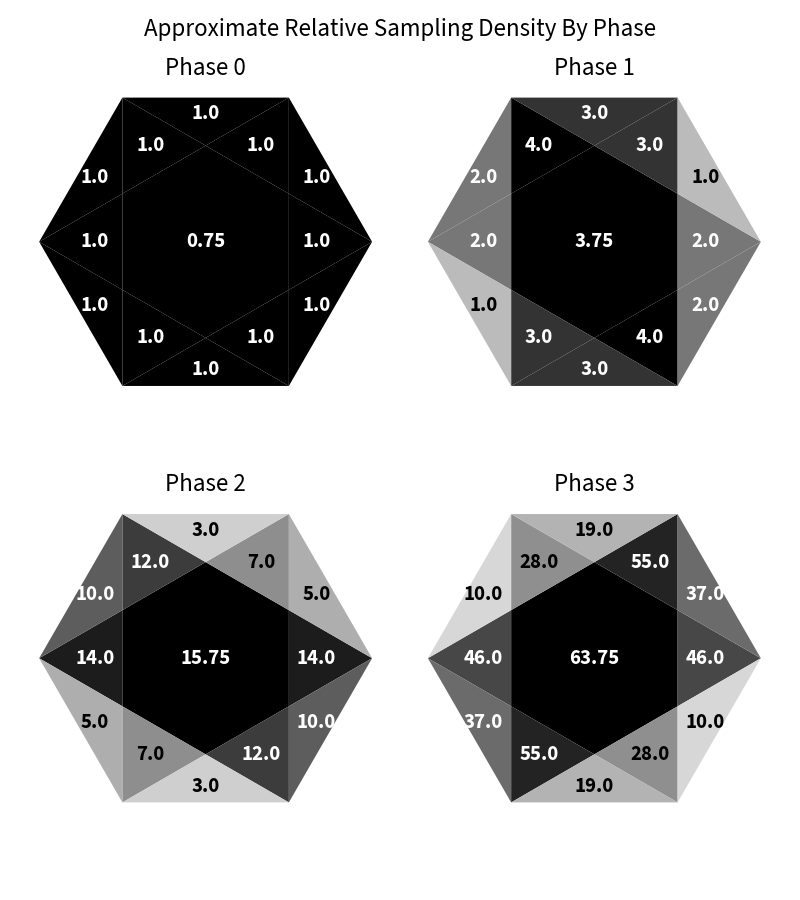

In [18]:
new_interior_weights = [
    3,
    12,
    48,
    192,
]
new_horn_weights = [
    [3, 2, 1, 3, 2, 1],
    [8, 4, 12, 8, 4, 12],
    [16, 48, 32, 16, 48, 32],
]
new_side_weights = [
    [2, 0, 1, 2, 0, 1],
    [0, 4, 8, 0, 4, 8],
    [16, 32, 0, 16, 32, 0],
    [128, 0, 64, 128, 0, 64],
]


fig, axs = plt.subplots(2, 2, figsize=(8, 9))
# for ax, i, h, s in zip(axs.ravel(), new_interior_weights, new_horn_weights, new_side_weights):
i = 3 / 4
h = np.ones(6)
s = np.ones(6)
isum = i
hsum = h.copy()
ssum = s.copy()
cumulative = True
for phase, ax in enumerate(axs.ravel()):
    ax.set_aspect("equal")
    ax.set_axis_off()
    # fig.colorbar(
    draw_hex(
        ax,
        exterior_outline=False,
        interior_weight=isum if cumulative else i,
        # draw_diameters=True,
        horn_weights=(hsum if cumulative else h).tolist(),
        side_weights=(ssum if cumulative else s).tolist(),
        cmap="gray_r",
        vmax=isum if cumulative else i,
    )
    #    ax=ax)
    if phase == 0:
        h = np.array([3, 2, 1, 3, 2, 1])
        s = np.array([2, 0, 1, 2, 0, 1])
        i *= 4
    else:
        s = np.roll(s, -1) * 4
        h = np.roll(h, -1) * 4
        i *= 4
    isum += i
    hsum += h
    ssum += s
    print(np.roll(ssum, phase % 3) / isum, np.roll(hsum, phase % 3) / isum)
    # print(hsum / isum, ssum/isum)
    ax.set_title(f"Phase {phase}")
fig.tight_layout()
fig.suptitle("Approximate Relative Sampling Density By Phase")

In [19]:
np.mean(ssum / isum), np.mean(hsum / isum)

(0.3362658846529814, 0.6686217008797654)

## Trimmed variant

For the trimmed variant, we plot different triangles. The trimming is 3/4 which makes the rectangles perfectly incident to the vertices of the interior hexagon.

Aa [-0.24999999999999994, 0.7216878364870323]


(255.75,
 array([220., 183., 110., 220., 183., 110.]),
 array([147.,  37.,  74., 147.,  37.,  74.]))

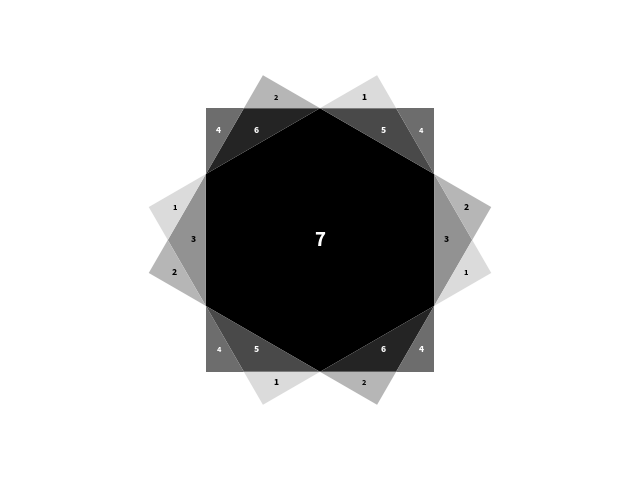

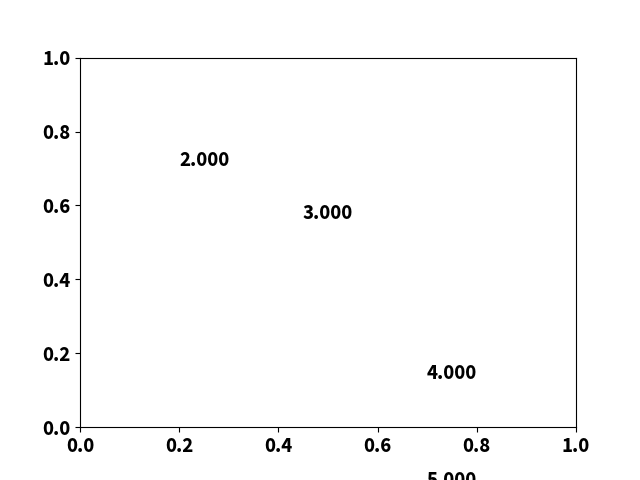

In [20]:
def midpoint(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    return (x + y) / 2


def hex_midpoints(extpts, intpts):
    out = []
    j = 0
    fig, ax = plt.subplots()
    for I, oa, ob in zip(
        intpts.tolist(), extpts.tolist(), np.roll(extpts, -1, axis=0).tolist()
    ):
        out.append(midpoint(I, oa))
        ax.text(out[-1][0], out[-1][1], f"{j+1:.03f}", ha="center", va="center")
        j += 1
        out.append(midpoint(I, ob))
        ax.text(out[-1][0], out[-1][1], f"{j+1:.03f}", ha="center", va="center")
        j += 1
    return np.asarray(out)


def draw_hex_trimmed(
    ax,
    exterior_outline=1,
    draw_diameters=0,
    draw_chords=0,
    interior_weight=None,  # Provide values here to color triangles, in order to display densities
    horn_weights=None,
    subhorn_weights=None,
    vmin=0,
    vmax=1,
    cmap=None,
):
    extpts = unit_hex_points()
    a, b, c, d, e, f = extpts.tolist()

    # plot invisible points so that the image extent is set properly
    ax.plot(extpts[:, 0], extpts[:, 1], alpha=0)

    # scale and rotate exterior polygon to get interior polygon
    intpts = rotate_points(extpts * np.sqrt(3) / 3, -np.pi / 6)
    A, B, C, D, E, F = intpts.tolist()

    # midpts of lines on horns
    midpts = hex_midpoints(extpts, intpts)
    Aa, Ab, Bb, Bc, Cc, Cd, Dd, De, Ee, Ef, Ff, Fa = midpts.tolist()
    print("Aa", Aa)
    # centers of horns
    centers = extpts * 2 / 3
    ca, cb, cc, cd, ce, cf = centers.tolist()

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)

    if interior_weight is not None:
        # plot a hexagon in the interior as a color given by colormap
        # plot_polyline(intpts, ax, color='b')
        p = Polygon(intpts, edgecolor=None, facecolor=mapper.to_rgba(interior_weight))
        ax.add_patch(p)
        ax.text(
            0,
            0,
            # f'{interior_weight:.03f}',
            str(interior_weight),
            ha="center",
            va="center",
            color="white",
        )

    if horn_weights is not None:
        if not isinstance(horn_weights, (list, tuple)):
            horn_weights = 6 * [horn_weights]
        for u, v, w, wt in zip(
            intpts.tolist(),
            centers.tolist(),
            np.roll(intpts, 1, axis=0).tolist(),
            horn_weights,
        ):
            ax.add_patch(
                Polygon([u, v, w], edgecolor=None, facecolor=mapper.to_rgba(wt))
            )
            x = (u[0] + v[0] + w[0]) / 3
            y = (u[1] + v[1] + w[1]) / 3
            ax.text(
                x,
                y,
                # f'{wt:.03f}',
                str(wt),
                ha="center",
                va="center",
                color="white" if wt / interior_weight > 0.5 else "black",
                fontsize=7,
            )

    if subhorn_weights is not None:
        if not isinstance(subhorn_weights, (list, tuple)):
            subhorn_weights = 12 * [subhorn_weights]
        for j, (i, ca, cb, ma, mb, wta, wtb) in enumerate(
            zip(
                intpts.tolist(),
                centers.tolist(),
                np.roll(centers, -1, axis=0).tolist(),
                midpts[::2],
                midpts[1::2],
                subhorn_weights[::2],
                subhorn_weights[1::2],
            )
        ):
            ax.add_patch(
                Polygon([ca, ma, i], edgecolor=None, facecolor=mapper.to_rgba(wta))
            )
            x = (ca[0] + ma[0] + i[0]) / 3
            y = (ca[1] + ma[1] + i[1]) / 3
            ax.text(
                x,
                y,
                # f'{wta:.03f}',
                str(wta),
                ha="center",
                va="center",
                color="white" if wta / interior_weight > 0.5 else "black",
                fontsize=6,
            )
            ax.add_patch(
                Polygon([cb, mb, i], edgecolor=None, facecolor=mapper.to_rgba(wtb))
            )
            x = (cb[0] + mb[0] + i[0]) / 3
            y = (cb[1] + mb[1] + i[1]) / 3
            ax.text(
                x,
                y,
                # f'{wtb:.03f}',
                str(wtb),
                ha="center",
                va="center",
                color="white" if wtb / interior_weight > 0.5 else "black",
                fontsize=7,
            )

    if exterior_outline:
        plot_polyline(extpts, ax, color="k")

    if draw_diameters:
        plot_polyline(np.vstack([a, d]), ax, color="k")
        plot_polyline(np.vstack([b, e]), ax, color="k")
        plot_polyline(np.vstack([c, f]), ax, color="k")

    if draw_chords:
        plot_polyline(np.vstack([a, c]), ax, color="k")
        plot_polyline(np.vstack([b, d]), ax, color="k")
        plot_polyline(np.vstack([c, e]), ax, color="k")
        plot_polyline(np.vstack([d, f]), ax, color="k")
        plot_polyline(np.vstack([e, a]), ax, color="k")
        plot_polyline(np.vstack([f, b]), ax, color="k")

    return mapper


fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_axis_off()
# fig.colorbar(
draw_hex_trimmed(
    ax,
    exterior_outline=False,
    interior_weight=7,  # 1.0
    vmax=7,
    # draw_diameters=True,
    # horn_weights=[0.85714286, 0.71428571, 0.42857143, 0.85714286, 0.71428571, 0.42857143], #[0.75,0.5,  0.25, 0.75, 0.5,  0.25], # new
    # subhorn_weights=[0.28571429, 0.14285715, 0.57142858, 0.28571429, 0.14285715, 0.57142858, 0.28571429, 0.14285715, 0.57142858, 0.28571429, 0.14285715, 0.57142858],
    horn_weights=[6, 5, 3, 6, 5, 3],
    subhorn_weights=[2, 1, 4, 2, 1, 4, 2, 1, 4, 2, 1, 4],
    # side_weights=[0.57142858, 0.14285715, 0.28571429, 0.57142858, 0.14285715, 0.28571429], #[0.5, 0.,   0.25, 0.5,  0.,   0.25], # new
    cmap="gray_r",
),
# ax=ax)

fig.tight_layout()
fig.savefig("../latex/converged_hex_density_trimmed.pdf", bbox_inches="tight")
isum, hsum, ssum

## Angular distribution plot

Area 1.5707859706879204
Area 1.2990381056766578
Area 2.487613791819716
Area 1.7339532180102122


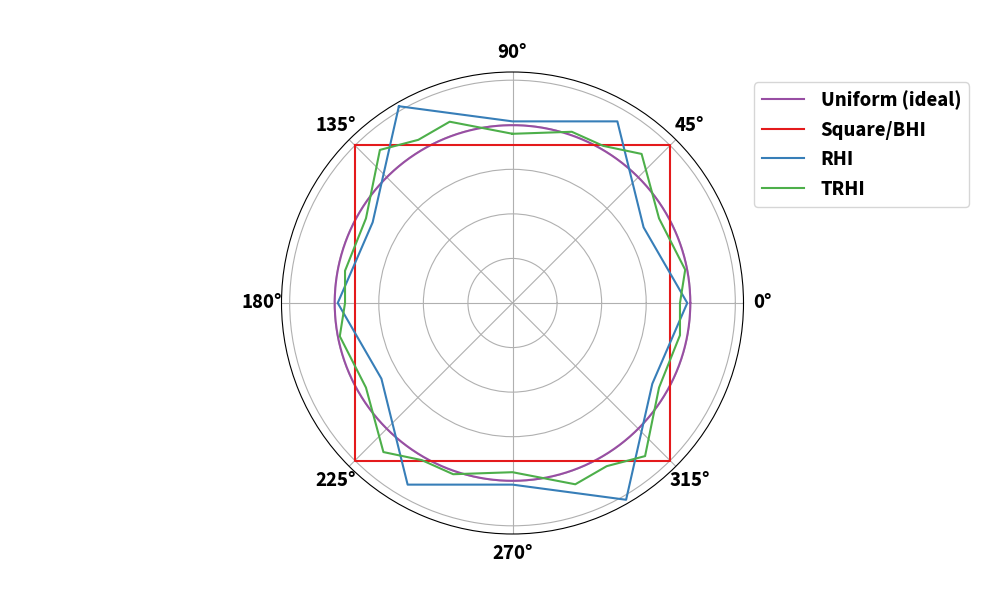

In [21]:
def rect_ang_density(h, w):
    """Given height and width of rectangle, return angular density (phi, density) pairs"""
    # get angles at corners
    phi0 = np.arctan(h / w)
    r = np.sqrt(h**2 + w**2) / 2
    phi = np.array(
        [
            np.pi - phi0,
            phi0,
            -phi0,
            phi0 - np.pi,
            np.pi - phi0,
        ]
    )
    return phi, r * np.ones_like(phi)


def rhi_ang_density(
    interior_weight=1.0,
    horn_weights=[
        0.85714286,
        0.71428571,
        0.42857143,
        0.85714286,
        0.71428571,
        0.42857143,
    ],  # [0.75,0.5,  0.25, 0.75, 0.5,  0.25], # new
    side_weights=[
        0.57142858,
        0.14285715,
        0.28571429,
        0.57142858,
        0.14285715,
        0.28571429,
    ],  # [0.5, 0.,   0.25, 0.5,  0.,   0.25], # new
    R=1,  # distance from center to vertex of _interior_ regular hexagon
):
    r = np.sqrt(3) * R / 2  # see https://en.wikipedia.org/wiki/Hexagon
    wR = R * interior_weight
    wr = r * interior_weight
    extR = 3 * R / np.sqrt(3)
    extr = 3 * r / np.sqrt(3)
    horn_height = extR - r
    side_height = extr - R
    wh = wr + horn_height * np.asarray(horn_weights)
    ws = wR + side_height * np.asarray(side_weights)
    radius = np.array([wh, ws]).T.ravel()
    radius = np.append(radius, radius[0])  # wrap back to start

    phi = np.linspace(np.pi / 2, np.pi / 2 - 2 * np.pi, 13) + np.pi / 6
    return phi, radius


def trhi_ang_density(
    interior_weight=1.0,
    horn_weights=[
        0.85714286,
        0.71428571,
        0.42857143,
        0.85714286,
        0.71428571,
        0.42857143,
    ],  # [0.75,0.5,  0.25, 0.75, 0.5,  0.25], # new
    subhorn_weights=[
        0.28571429,
        0.14285715,
        0.57142858,
        0.28571429,
        0.14285715,
        0.57142858,
        0.28571429,
        0.14285715,
        0.57142858,
        0.28571429,
        0.14285715,
        0.57142858,
    ],
    R=1,  # distance from center to vertex of _interior_ regular hexagon
):
    r = np.sqrt(3) * R / 2  # see https://en.wikipedia.org/wiki/Hexagon
    wR = R * interior_weight
    wr = r * interior_weight
    # horn side length = interior R
    extR = 3 * R / np.sqrt(3)
    extr = 3 * r / np.sqrt(3)
    # NOTE: this differs from RHI calculation since horns are 1/3 the area now
    horn_height = (extR - r) / 3

    H = R * np.sqrt(7) / 2  # distance from center to subhorn tip
    rsh = (
        H * 2 / 3
    )  # distance from center to interior polygon on ray toward subhorn tip
    sh_height = (
        H / 6
    )  # On line through subhorn tip, intersects three regions: interior, horn, subhorn. Horn/subhorn are bisected equally.
    horn_at_sh_height = H / 6
    wsh = rsh * interior_weight  # fixed weight of interior portion at subhorn tips
    sh_theta = np.arctan(
        1 / (3 * np.sqrt(3))
    )  # angle between horn tip and subhorn tips

    wtip = wR  # pointy tips of interior have no peripheral regions
    wh = wr + horn_height * np.asarray(horn_weights)
    ws = wR + sh_height * np.asarray(subhorn_weights)
    radius = np.array([wh, ws], dtype=object).T.ravel()
    radius = np.append(radius, radius[0])  # wrap back to start

    phi = np.linspace(np.pi / 2, np.pi / 2 - 2 * np.pi, 13) + np.pi / 6

    phi = [
        3 * np.pi / 6,  # North tip
        2 * np.pi / 6 + sh_theta,
        2 * np.pi / 6,  # NNE horn
        2 * np.pi / 6 - sh_theta,
        np.pi / 6,  # ENE tip,
        sh_theta,
        0,  # East horn
        -sh_theta,
        -np.pi / 6,  # ESE
        -2 * np.pi / 6 + sh_theta,
        -2 * np.pi / 6,  # SSE horn
        -2 * np.pi / 6 - sh_theta,
        -3 * np.pi / 6,  # S
        -4 * np.pi / 6 + sh_theta,
        -4 * np.pi / 6,  # SSW horn
        -4 * np.pi / 6 - sh_theta,
        -5 * np.pi / 6,  # S
        -6 * np.pi / 6 + sh_theta,
        -6 * np.pi / 6,  # SSW horn
        -6 * np.pi / 6 - sh_theta,
        -7 * np.pi / 6,  # S
        -8 * np.pi / 6 + sh_theta,
        -8 * np.pi / 6,  # SSW horn
        -8 * np.pi / 6 - sh_theta,
        -9 * np.pi / 6,  # S
    ]
    radius = [
        wtip,  # N
        wsh
        + horn_weights[1] * horn_at_sh_height  # interior
        + subhorn_weights[1] * sh_height,  # horn  # subhorn
        wr + horn_weights[1] * horn_height,
        wsh + horn_weights[1] * horn_at_sh_height + subhorn_weights[2] * sh_height,
        wtip,  # ENE
        wsh + horn_weights[2] * horn_at_sh_height + subhorn_weights[3] * sh_height,
        wr + horn_weights[2] * horn_height,  # E
        wsh + horn_weights[2] * horn_at_sh_height + subhorn_weights[4] * sh_height,
        wtip,  # ESE
        wsh + horn_weights[3] * horn_at_sh_height + subhorn_weights[5] * sh_height,
        wr + horn_weights[3] * horn_height,  # SSE
        wsh + horn_weights[3] * horn_at_sh_height + subhorn_weights[6] * sh_height,
        wtip,  # S
        wsh + horn_weights[4] * horn_at_sh_height + subhorn_weights[7] * sh_height,
        wr + horn_weights[4] * horn_height,  # SSE
        wsh + horn_weights[4] * horn_at_sh_height + subhorn_weights[8] * sh_height,
        wtip,  # S
        wsh + horn_weights[5] * horn_at_sh_height + subhorn_weights[9] * sh_height,
        wr + horn_weights[5] * horn_height,  # SSE
        wsh + horn_weights[5] * horn_at_sh_height + subhorn_weights[10] * sh_height,
        wtip,  # S
        wsh + horn_weights[0] * horn_at_sh_height + subhorn_weights[11] * sh_height,
        wr + horn_weights[0] * horn_height,  # SSE
        wsh + horn_weights[0] * horn_at_sh_height + subhorn_weights[0] * sh_height,
        wtip,  # S
    ]

    return phi, radius


def normalize_area(phi, r):
    """Normalize r to produce unit area polygon"""
    x = np.cos(phi) * r
    y = np.sin(phi) * r
    # use shoelace formula to get area
    A = np.abs((x[:-1] * y[1:] - x[1:] * y[1:]).sum()) / 2
    print("Area", A)
    return phi, r / np.sqrt(A)


def circle():
    phi = np.linspace(0, 2 * np.pi, 1000)
    r = np.ones_like(phi)
    return phi, r


fig, ax = plt.subplots(
    figsize=(10, 6),
    subplot_kw={"projection": "polar"},
)
area = 3 * np.sqrt(3) / 2
# ax.plot(*rect_ang_density(np.sqrt(3) * 2 / 3 * np.sqrt(area), np.sqrt(area) * 1.5 / np.sqrt(3)), label='Rect')
ax.plot(*normalize_area(*circle()), label="Uniform (ideal)", color="#984ea3")
ax.plot(
    *normalize_area(*rect_ang_density(np.sqrt(area), np.sqrt(area))),
    label="Square/BHI",
    color="#e41a1c"
)
ax.plot(*normalize_area(*rhi_ang_density()), label="RHI", color="#377eb8")
ax.plot(*normalize_area(*trhi_ang_density()), label="TRHI", color="#4daf4a")
ax.set_yticklabels([])
ax.legend(bbox_to_anchor=(1, 1), loc="upper left")
fig.savefig("../latex/angular_density.pdf", bbox_inches="tight")

# Points per phase/subscan

Here I'll plot something like a Gantt chart for the various phases or subscans using each method.

/var/folders/hp/prgj5tj15w52gft1_qqgj4cw2tv1y4/T/ipykernel_22195/2345881229.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 3))


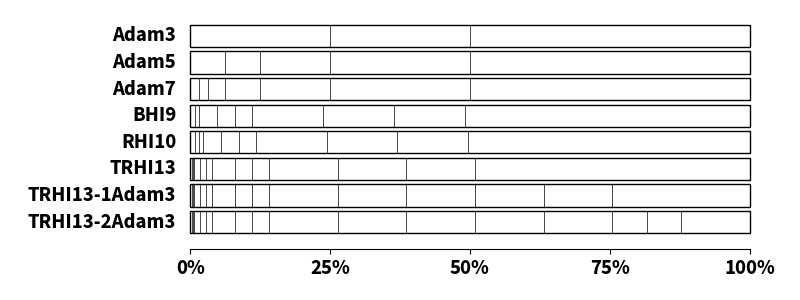

In [22]:
def plot_splits(named_splits, ax, spacing=0.6, ht=0.5, width=10):
    for i, (name, splits) in enumerate(named_splits):
        ax.text(-0.25, -i * spacing, name, ha="right", va="center")
        box = np.array(
            [
                (0, -ht / 2 - i * spacing),
                (0, ht / 2 - i * spacing),
                (width, ht / 2 - i * spacing),
                (width, -ht / 2 - i * spacing),
            ]
        )
        sw, nw, ne, se = box[0], box[1], box[2], box[3]
        ax.add_patch(Polygon([nw, ne, se, sw, nw], edgecolor="k", lw=1, fill=None))

        tot = sum(splits)
        cs = np.cumsum(splits)
        for ci in cs:
            t = ci / tot
            bot = sw * (1 - t) + se * t
            top = nw * (1 - t) + ne * t
            plt.plot([bot[0], top[0]], [bot[1], top[1]], "k-", markersize=None, lw=0.5)
    ax.set_xlim(-1.5, width + 0.5)
    ax.set_ylim(-(len(named_splits)) * spacing, 0.5 * spacing)

    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([0, 0.25 * width, 0.5 * width, 0.75 * width, width])
    ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"])
    ax.spines["bottom"].set_bounds(0, width)


fig, ax = plt.subplots(figsize=(8, 3))
# ax.set_axis_off()
# Adam7
plot_splits(
    [
        ("Adam3", [1 / 64, 1 / 64, 1 / 32]),
        ("Adam5", [1 / 64, 1 / 64, 1 / 32, 1 / 16, 1 / 8]),
        ("Adam7", [1 / 64, 1 / 64, 1 / 32, 1 / 16, 1 / 8, 1 / 4, 1 / 2]),
        ("BHI9", [6, 6, 24, 24, 24, 96, 96, 96, 384]),
        ("RHI10", [1, 1, 1, 4, 4, 4, 16, 16, 16, 64]),
        ("TRHI13", [1, 1, 1, 4, 4, 4, 16, 12, 12, 48, 48, 48, 192]),
        ("TRHI13-1Adam3", [1, 1, 1, 4, 4, 4, 16, 12, 12, 48, 48, 48, 48, 48, 96]),
        (
            "TRHI13-2Adam3",
            [1, 1, 1, 4, 4, 4, 16, 12, 12, 48, 48, 48, 48, 48, 24, 24, 48],
        ),
    ],
    ax,
)
fig.tight_layout()
fig.savefig("../latex/subscan_splits.pdf", bbox_inches="tight")

The plot below is same as above but using colored bar segments instead of boxes.

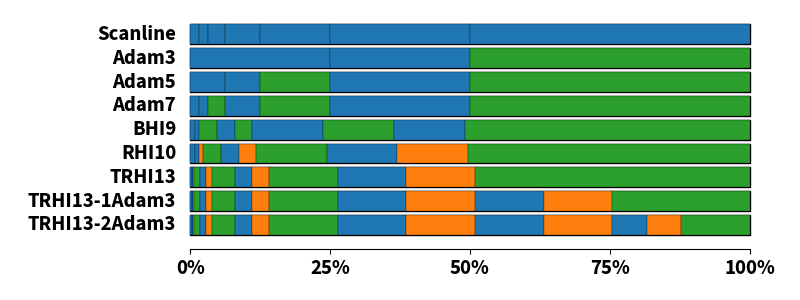

In [23]:
def plot_splits_color(named_splits, ax, spacing=0.6, ht=0.5, width=10):
    # color defs
    named_colors = dict(
        b="#1f77b4",
        o="#ff7f0e",
        g="#2ca02c",
    )
    for i, (name, splits, colors) in enumerate(named_splits):
        ax.text(-0.25, -i * spacing, name, ha="right", va="center")
        box = np.array(
            [
                (0, -ht / 2 - i * spacing),
                (0, ht / 2 - i * spacing),
                (width, ht / 2 - i * spacing),
                (width, -ht / 2 - i * spacing),
            ]
        )
        sw, nw, ne, se = box[0], box[1], box[2], box[3]
        ax.add_patch(Polygon([nw, ne, se, sw, nw], edgecolor="k", lw=1, fill=None))

        tot = sum(splits)
        left = 0
        for j, ci in enumerate(splits):
            t = ci / tot * width
            bot = sw * (1 - t) + se * t
            top = nw * (1 - t) + ne * t
            box = np.array(
                [
                    (left, -ht / 2 - i * spacing),
                    (left, ht / 2 - i * spacing),
                    (left + t, ht / 2 - i * spacing),
                    (left + t, -ht / 2 - i * spacing),
                ]
            )
            sw, nw, ne, se = box[0], box[1], box[2], box[3]
            if j >= len(colors):
                break
            ax.add_patch(
                Polygon(
                    [nw, ne, se, sw, nw],
                    edgecolor="k",
                    lw=0.2,
                    facecolor=named_colors.get(colors[j], "k"),
                )
            )
            left += t
    ax.set_xlim(-1.5, width + 0.5)
    ax.set_ylim(-(len(named_splits)) * spacing, 0.5 * spacing)

    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([0, 0.25 * width, 0.5 * width, 0.75 * width, width])
    ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"])
    ax.spines["bottom"].set_bounds(0, width)


fig, ax = plt.subplots(figsize=(8, 3))
# ax.set_axis_off()
# name, amounts, colors to cycle
plot_splits_color(
    [
        (
            "Scanline",
            [1 / 64, 1 / 64, 1 / 32, 1 / 16, 1 / 8, 1 / 4, 1 / 2],
            "bbbbbbbbb",
        ),
        ("Adam3", [1 / 64, 1 / 64, 1 / 32], "bbg"),
        ("Adam5", [1 / 64, 1 / 64, 1 / 32, 1 / 16, 1 / 8], "bbgbg"),
        ("Adam7", [1 / 64, 1 / 64, 1 / 32, 1 / 16, 1 / 8, 1 / 4, 1 / 2], "bbgbgbg"),
        ("BHI9", [6, 6, 24, 24, 24, 96, 96, 96, 384], "bbgbgbgbg"),
        ("RHI10", [1, 1, 1, 4, 4, 4, 16, 16, 16, 64], "bbogbogbog"),
        ("TRHI13", [1, 1, 1, 4, 4, 4, 16, 12, 12, 48, 48, 48, 192], "bbogbogbogbog"),
        (
            "TRHI13-1Adam3",
            [1, 1, 1, 4, 4, 4, 16, 12, 12, 48, 48, 48, 48, 48, 96],
            "bbogbogbogbobog",
        ),
        (
            "TRHI13-2Adam3",
            [1, 1, 1, 4, 4, 4, 16, 12, 12, 48, 48, 48, 48, 48, 24, 24, 48],
            "bbogbogbogbobobog",
        ),
    ],
    ax,
)
fig.tight_layout()
fig.savefig("../latex/subscan_splits_color.pdf", bbox_inches="tight")

## Hex overlap calculations

For 2D Gaussians, both with same $\sigma$, spaced some distance $\Delta$ from one another, the overlap can be computed by integrating their product. If you work out that exercise you find the overlap, relative to the integral of a single bump, is $\exp\left(-\frac{\Delta}{(2\sigma)^2}\right)/2$.

We can also work out the density of a square grid with spacing $\Delta$, which is simply $1/\Delta^2$. A hex grid whose probe have spacing $w$, has a density of $\frac{2}{\sqrt{3} w^2}$. Setting these densities equal, we see that the equivalent hex grid has slightly larger spacing $w=\sqrt{\frac{2}{\sqrt{3}}}\Delta\approx 1.075\Delta$.

A point on a hex grid has six nearest neighbors at distance $w$, six at $\sqrt{3}w$, and six at $2w$. A point on a square grid has four neighbors at distance $\Delta$, four at distance $\sqrt{2}\Delta$, and multiple at distance $2\Delta$ or more away.

Here I will compute the overlap to the nearest neighbors, and then verify that further neighbors have a negligible effect on the result.

In [24]:
delta = 1.0  # in units of sigma
w = np.sqrt(2 / np.sqrt(3)) * delta


def gaussian_overlap(spacing):
    """Overlap as function of spacing relative to sigma"""
    return np.exp(-((spacing / 2) ** 2)) / 2


hex_nearest_overlap = 6 * gaussian_overlap(w)
square_nearest_overlap = 4 * gaussian_overlap(delta)
hex_nearest_overlap, square_nearest_overlap, hex_nearest_overlap / square_nearest_overlap

(2.247766719254993, 1.5576015661428098, 1.443094799154115)

In [25]:
hex_next_nearest_overlap = 6 * gaussian_overlap(w * np.sqrt(3)) + 6 * gaussian_overlap(
    w * 2
)
square_next_nearest_overlap = 4 * gaussian_overlap(
    delta * np.sqrt(2)
) + 4 * gaussian_overlap(delta * 2)
hex_next_nearest_overlap, square_next_nearest_overlap, (
    hex_nearest_overlap + hex_next_nearest_overlap
) / (square_nearest_overlap + square_next_nearest_overlap)

(2.2073157741789515, 1.9488202017681513, 1.2705495197995453)

## Montage plots

## Square montage

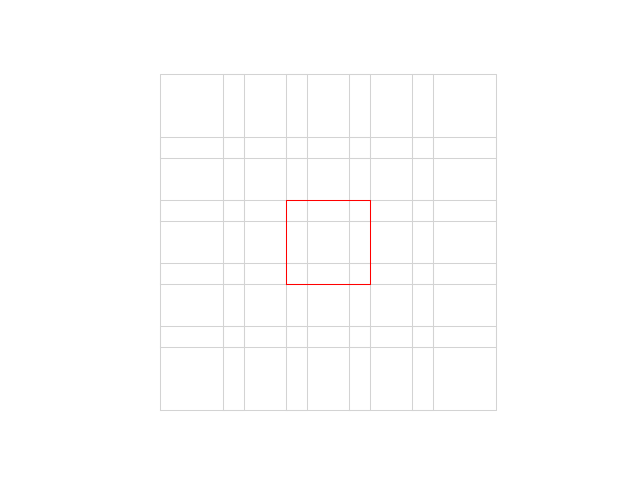

In [26]:
def plot_square(
    location,
    color,
    width=1.0,
    ax=None,
    **kwargs,
):
    if ax is None:
        ax = plt.gca()
    pts = (
        np.array(
            [
                [-0.5, -0.5],
                [-0.5, 0.5],
                [0.5, 0.5],
                [0.5, -0.5],
                [-0.5, -0.5],
            ]
        )
        * width
    )
    ax.plot(
        pts[:, 0] + location[0],
        pts[:, 1] + location[1],
        color=color,
        **kwargs,
    )


def plot_rect_grid(
    grid_size,
    tile_callback,
    offset=[0, 0],
    spacing=[1, 1],
    center_kwargs=None,
    regular_kwargs={},
    **kwargs,
):
    # draw center special only for odd grid sizes
    skipcenter = grid_size[0] % 2 == 1 and grid_size[1] % 2 == 1
    for i in range(-(grid_size[0] - 1) // 2, (grid_size[0] + 1) // 2):
        for j in range(-(grid_size[1] - 1) // 2, (grid_size[1] + 1) // 2):
            if skipcenter and i == 0 and j == 0:
                continue  # draw center tile last
            tile_callback(
                [
                    i * spacing[0] + offset[0],
                    j * spacing[1] + offset[1],
                ],
                **regular_kwargs,
                **kwargs,
            )
    if skipcenter:
        tile_callback(
            [0, 0],
            **(center_kwargs if center_kwargs is not None else regular_kwargs),
            **kwargs,
        )


overlap = 0.25
fig, ax = plt.subplots()
plot_rect_grid(
    [5, 5],
    plot_square,
    spacing=[1 - overlap, 1 - overlap],
    center_kwargs=dict(
        color="red",
    ),
    regular_kwargs=dict(
        color="lightgray",
    ),
    ax=ax,
    lw=0.75,
)
ax.set_aspect("equal")
ax.set_axis_off()
fig.savefig("../latex/square_montage.pdf", bbox_inches="tight")

## Hex montage

### Tight

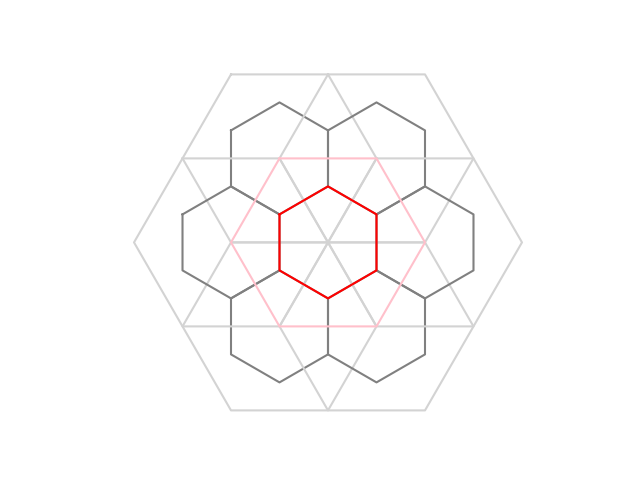

In [27]:
def plot_hex(
    location,
    interior_color,
    exterior_color,
    width=1.0,
    ax=None,
    **kwargs,
):
    extpts = unit_hex_points() * width
    extpts = np.vstack([extpts, extpts[[0], :]])

    # scale and rotate exterior polygon to get interior polygon
    intpts = rotate_points(extpts * np.sqrt(3) / 3, np.pi / 6)

    ax.plot(
        extpts[:, 0] + location[0],
        extpts[:, 1] + location[1],
        color=exterior_color,
    )
    ax.plot(
        intpts[:, 0] + location[0],
        intpts[:, 1] + location[1],
        color=interior_color,
    )


def plot_tight_grid(
    tile_callback,
    offset=[0, 0],
    spacing=[1, 1],
    center_kwargs=None,
    regular_kwargs={},
    **kwargs,
):
    # 2x2 top/bottom
    plot_rect_grid(
        [2, 2],
        tile_callback,
        offset=[0.5, np.sqrt(3) / 2],
        spacing=[1.0, np.sqrt(3)],
        regular_kwargs=regular_kwargs,
        **kwargs,
    )
    # 1x3 middle row at 0,0 offset
    plot_rect_grid(
        [3, 1],
        tile_callback,
        offset=[0, 0],
        spacing=[1.0, np.sqrt(3)],
        regular_kwargs=regular_kwargs,
        center_kwargs=center_kwargs,
        **kwargs,
    )


fig, ax = plt.subplots()
plot_tight_grid(
    plot_hex,
    center_kwargs=dict(
        interior_color="red",
        exterior_color="pink",
    ),
    regular_kwargs=dict(
        interior_color="gray",
        exterior_color="lightgray",
    ),
    ax=ax,
    lw=0.75,
)
ax.set_aspect("equal")
ax.set_axis_off()
fig.savefig("../latex/hex_montage_tight_untrimmed.pdf", bbox_inches="tight")

### Loose

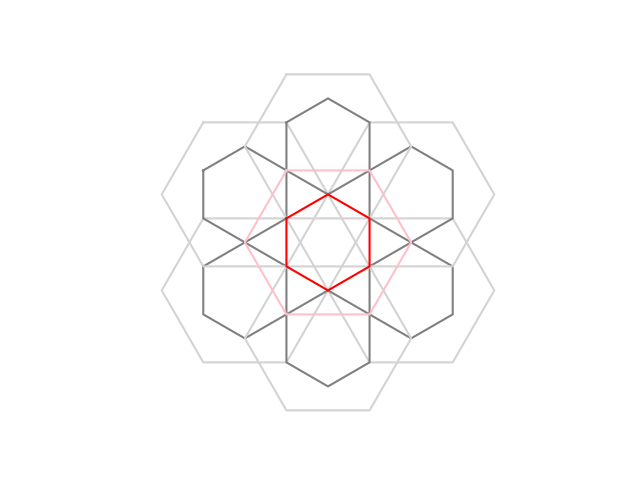

In [28]:
def plot_loose_grid(
    tile_callback,
    offset=[0, 0],
    spacing=[1, 1],
    center_kwargs=None,
    regular_kwargs={},
    **kwargs,
):
    # 2x2 top/bottom
    plot_rect_grid(
        [2, 2],
        tile_callback,
        offset=[1.0, np.sqrt(3) / 3],
        spacing=[2.0, np.sqrt(3) * 2 / 3],
        regular_kwargs=regular_kwargs,
        **kwargs,
    )
    # 3x1 middle row at 0,0 offset
    plot_rect_grid(
        [1, 3],
        tile_callback,
        offset=[0, 0],
        spacing=[1.0, np.sqrt(3) * 2 / 3],
        regular_kwargs=regular_kwargs,
        center_kwargs=center_kwargs,
        **kwargs,
    )


fig, ax = plt.subplots()
plot_loose_grid(
    plot_hex,
    center_kwargs=dict(
        interior_color="red",
        exterior_color="pink",
    ),
    regular_kwargs=dict(
        interior_color="gray",
        exterior_color="lightgray",
    ),
    ax=ax,
    lw=0.75,
)
ax.set_aspect("equal")
ax.set_axis_off()
fig.savefig("../latex/hex_montage_loose_untrimmed.pdf", bbox_inches="tight")

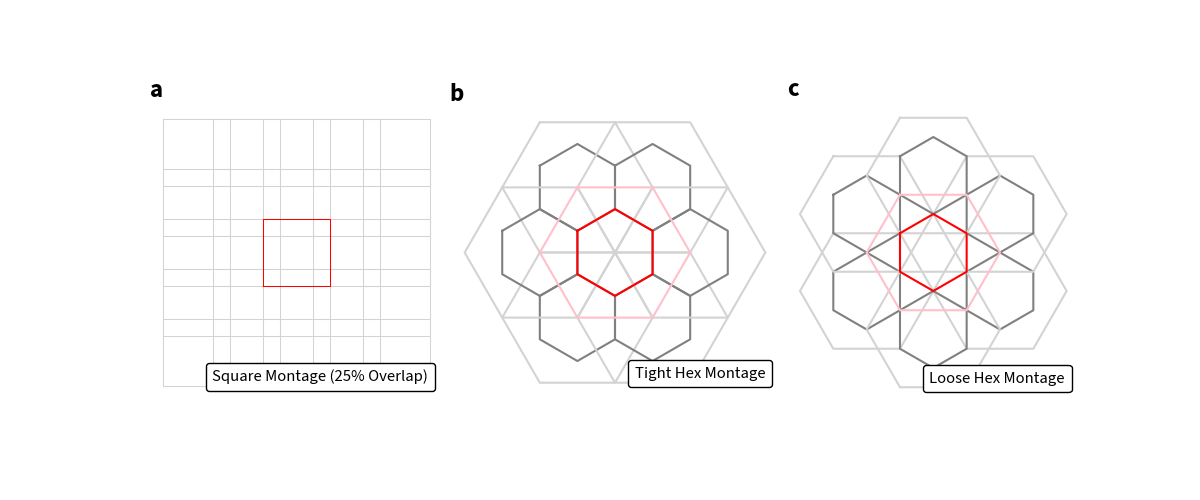

In [45]:
fig = plt.figure(figsize=(12, 5))

gs = mpgs.GridSpec(10, 25)
ax1 = plt.subplot(gs[0:10, 0:8])
ax2 = plt.subplot(gs[0:10, 8:17])
ax3 = plt.subplot(gs[0:10, 17:25])

cc = 0

plot_rect_grid(
    [5, 5],
    plot_square,
    spacing=[1 - overlap, 1 - overlap],
    center_kwargs=dict(
        color="red",
    ),
    regular_kwargs=dict(
        color="lightgray",
    ),
    ax=ax1,
    lw=0.75,
)
at = mploff.AnchoredText(
    "Square Montage (25% Overlap)",
    prop=sc_font,
    frameon=True,
    loc="lower right",
)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
ax1.axis("off")
ax1.set_aspect("equal")
ax1.set_title(label=string.ascii_lowercase[cc], loc="left", fontdict=tl_font)
cc += 1

plot_tight_grid(
    plot_hex,
    center_kwargs=dict(
        interior_color="red",
        exterior_color="pink",
    ),
    regular_kwargs=dict(
        interior_color="gray",
        exterior_color="lightgray",
    ),
    ax=ax2,
    lw=0.75,
)
at = mploff.AnchoredText(
    "Tight Hex Montage",
    prop=sc_font,
    frameon=True,
    loc="lower right",
)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)
ax2.axis("off")
ax2.set_aspect("equal")
ax2.set_title(label=string.ascii_lowercase[cc], loc="left", fontdict=tl_font)
cc += 1

plot_loose_grid(
    plot_hex,
    center_kwargs=dict(
        interior_color="red",
        exterior_color="pink",
    ),
    regular_kwargs=dict(
        interior_color="gray",
        exterior_color="lightgray",
    ),
    ax=ax3,
    lw=0.75,
)
at = mploff.AnchoredText(
    "Loose Hex Montage",
    prop=sc_font,
    frameon=True,
    loc="lower right",
)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at)
ax3.axis("off")
ax3.set_aspect("equal")
ax3.set_title(label=string.ascii_lowercase[cc], loc="left", fontdict=tl_font)
cc += 1

fig.savefig("../latex/combined_montage.pdf", bbox_inches="tight")